In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
import pickle
# Add the function directory to the path
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from Slicing import Slicing
from fio import readin
from TurStat import TurStat
from tqdm import tqdm
from visualization import contour_generator

In [27]:
def shape_input(N, snapshot):
    x = np.reshape(np.array(snapshot.x), (N,N,N))
    y = np.reshape(np.array(snapshot.y), (N,N,N))
    z = np.reshape(np.array(snapshot.z), (N,N,N))
    ux = np.reshape(np.array(snapshot['u.x']), (N,N,N))
    uy = np.reshape(np.array(snapshot['u.y']), (N,N,N))
    uz = np.reshape(np.array(snapshot['u.z']), (N,N,N))
#     Evis = np.reshape(np.array(snapshot['Evis']), (N,N,N))
    dudy = np.reshape(np.array(snapshot['dudy']), (N,N,N))
    p = np.reshape(np.array(snapshot['p']), (N,N,N))
    gx = np.reshape(np.array(snapshot['g.x']), (N,N,N))
    return x,y,z,ux,uy,uz,dudy,p,gx

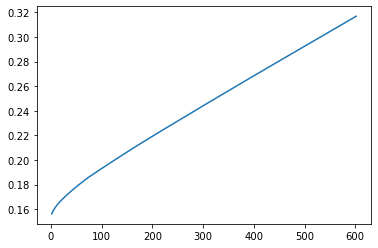

In [98]:
filename = '/home/jiarong/research/projects/turbulence/uniform_forcing_weaker_test/stats.dat'
stats1 = pd.read_table(filename, delimiter = ' ')
filename = '/home/jiarong/research/projects/turbulence/uniform_forcing_test/stats.dat'
stats2 = pd.read_table(filename, delimiter = ' ')
plt.plot(stats1.t[2:], stats1.energy[2:])
# plt.plot(stats2.t, stats2.dissipation)

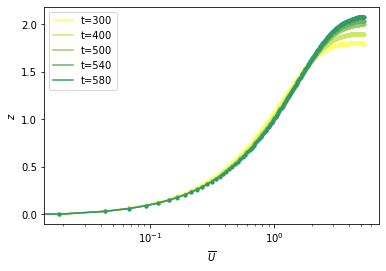

In [104]:
time_stamp = np.array([300,400,500,540,580])
ux_ensemble = []
slope_ensemble = []
for i in range(0,time_stamp.size):
    filename = "/home/jiarong/research/projects/turbulence/uniform_forcing_weaker_test/field_%g" % time_stamp[i]
    snapshot = pd.read_table(filename, delimiter = ',')
    snapshot = snapshot.sort_values(by = ['x','y','z'])
    x,y,z,ux,uy,uz,dudy,p,gx = shape_input(2**8,snapshot)
    uxarray = []
    yarray = y[0,:,0]
    for iy in range(0,np.size(yarray)):
        uxslice = ux[:,iy,:]
        uxarray.append(np.average(uxslice))
    plt.plot(yarray[40:]-1, uxarray[40:], label='t=%g' % time_stamp[i], color=plt.cm.get_cmap('summer')(1-i/time_stamp.size))
    plt.plot(yarray[40:]-1, uxarray[40:], '.', color=plt.gca().lines[-1].get_color())
    plt.legend()
    ux_ensemble.append(uxarray)
    slope = (uxarray[50]-uxarray[41])/(np.log(yarray[50])-np.log(yarray[41])) 
    slope_ensemble.append(slope)
plt.xlabel('$\overline{U}$')
plt.ylabel('$z$')
plt.xscale('log')
ux_ensemble = np.array(ux_ensemble)
slope_ensemble = np.array(slope_ensemble)

[1.3140361171951913, 1.2454118183658724, 1.210228368450113, 1.2016775713507013, 1.1953616756391015]


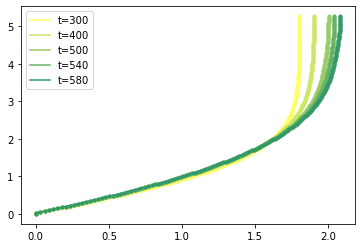

In [105]:
dudx_ensemble = []
for i in range(0,time_stamp.size):
    plt.plot(ux_ensemble[i,40:], yarray[40:]-1, label='t=%g' % time_stamp[i], color=plt.cm.get_cmap('summer')(1-i/time_stamp.size))
    plt.plot(ux_ensemble[i,40:], yarray[40:]-1, '.', color=plt.gca().lines[-1].get_color())
    dudx = (ux_ensemble[i,45]-ux_ensemble[i,42])/(yarray[45]-yarray[42])
    dudx_ensemble.append(dudx)
plt.legend()
print(dudx_ensemble)

2.1317003124737
1.2212


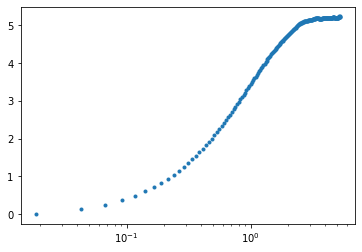

In [55]:
plt.plot(yarray[40:]-1, ux_ensemble[2,40:], '.')
plt.xscale('log')
slope = (uxarray[90]-uxarray[80])/(np.log(yarray[90]-1)-np.log(yarray[80]-1))
print(slope)
print(yarray[90]-1)

In [56]:
print(slope_ensemble)
slope = 2
print((2*0.4)**2/(2*np.pi-1))
print(0.01*(2*np.pi-1))

[5.18046656 5.23250319 5.28353834]
0.12113904070907222
0.052831853071795866


In [117]:
nu = 2*np.pi/40000/(1/850)*(17.4e-6/8.9e-4)
dudy = 1.2
tau = dudy*nu
aH = (2*np.pi-1)*0.001
print('stress from viscous sublayer = %g' %tau)
print('stress from pressure gradient = %g' %aH)
delta_nu = nu/aH**0.5
print('viscous length scale = %g' %delta_nu)
delta_grid = 2*np.pi/2**8
print('grid spacing = %g' %delta_grid)
H = 2*np.pi-1
print('RE_tau = %g' %(H/delta_nu))

stress from viscous sublayer = 0.00313241
stress from pressure gradient = 0.00528319
viscous length scale = 0.0359129
grid spacing = 0.0245437
RE_tau = 147.111


In [3]:
filename = '/home/jiarong/research/projects/turbulence/twophase_uniform_forcing_weaker/eta_t'
interface = pd.read_table(filename, delimiter = ',')

In [8]:
(interface.size/6)**0.5

256.0

In [ ]:
N = 256
interface = interface.sort_values(by = ['x','y'])
x = np.reshape(np.array(interface.x), (N,N))
y = np.reshape(np.array(interface.y), (N,N))
pos = np.reshape(np.array(interface.pos), (N,N))
grid = contour_generator()
image = np.rot90(pos)
# image = gx[15,:,:]+gradient
# xarray = x[:,0,0]; yarray = y[0,:,0]; zpoint = z[0,0,16]
pcontour = grid[0].imshow(image, extent=[x[0,0],x[-1,0],y[0,0],y[0,-1]])

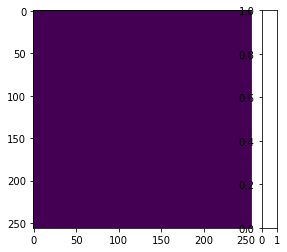

In [21]:
grid = contour_generator()
image = np.rot90(y)
# image = gx[15,:,:]+gradient
# xarray = x[:,0,0]; yarray = y[0,:,0]; zpoint = z[0,0,16]
pcontour = grid[0].imshow(image)

In [136]:
filename = "/home/jiarong/research/projects/turbulence/uniform_forcing_test/field_%g" % 350
snapshot = pd.read_table(filename, delimiter = ',')
snapshot = snapshot.sort_values(by = ['x','y','z'])
x,y,z,ux,uy,uz,dudy,p,gx = shape_input(2**8,snapshot)

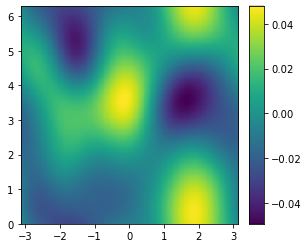

In [140]:
grid = contour_generator()
tau_wall = 0.01*(2*np.pi-1)
image = np.rot90(gx[:,42,:]-0.01)
pcontour = grid[0].imshow(image/tau_wall, extent=[-np.pi,np.pi,0,2*np.pi])
grid[0].cax.colorbar(pcontour)

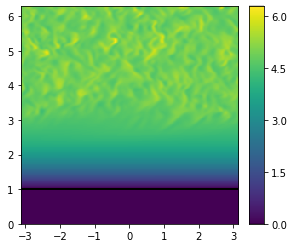

In [141]:
grid = contour_generator()
image = np.rot90(ux[:,:,127])
pcontour = grid[0].imshow(image, extent=[-np.pi,np.pi,0,2*np.pi], vmin=0)
grid[0].cax.colorbar(pcontour)
xarray = x[:,1,1]
eta = np.ones(xarray.size)
# eta = 1 + 0.1*np.sin(4*xarray)
grid[0].plot(xarray, eta, color='k', linewidth=2)

16


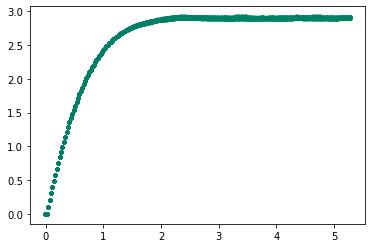

In [84]:
x_sample = np.arange(0,256,16)
print(x_sample.size)
ux_series = []
for i in range(x_sample.size):
    uxarray = []
    yarray = y[0,:,0]
    for iy in range(0,np.size(yarray)):
        uxslice = ux[x_sample[i],iy,:]
        uxarray.append(np.average(uxslice))
    plt.plot(yarray[40:]-1, uxarray[40:], '.', label='x_index%g' % i, color=plt.cm.get_cmap('summer')(1-i/time_stamp.size))
    ux_series.append(uxarray)

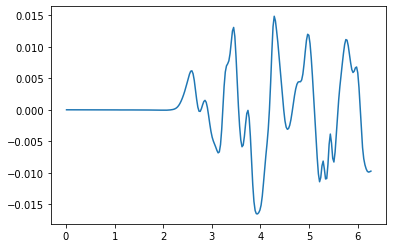

In [86]:
plt.plot(yarray, np.array(ux_series[3])-np.array(ux_series[4]))

In [ ]:
from scipy.interpolate import Rbf
x, y, z, d = np.random.rand(4, 50)
rbfi = Rbf(x, y, z, d)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(xi, yi, zi)   # interpolated values
di.shape